# Professional Weir Flow Analysis Notebook

This notebook offers detailed analysis of weir flows with:
- Multiple profile visualization
- Specific energy and hydraulic jump analysis
- Exportable plots and downloadable tabular results

## 📘 Notebook Outline

This notebook is designed to model open channel flow upstream of a weir, offering:

- **Critical depth** calculation
- **Normal depth** (for reference)
- **Backwater profile computation** via gradually varied flow (GVF) equation
- **Specific energy** at the starting depth
- **Hydraulic jump analysis** using sequent depth relations
- **Visualization** of multiple flow scenarios
- **Data exports** for further analysis or reporting

## 🧠 Approach & Equations

**1. Critical Depth Calculation:**  
$$
y_c = \left( \frac{Q^2}{g b^2} \right)^{1/3}
$$

**2. Normal Depth (Rectangular Channel, Manning’s Equation):**  
$$
Q = \frac{1}{n} b y^{5/3} \sqrt{S_0}
$$

**3. Gradually Varied Flow Equation (Backwater Profile):**  
$$
\frac{dy}{dx} = \frac{S_0 - S_f}{1 - Fr^2}
$$
where:  
$$
S_f = \frac{n^2 Q^2}{A^2 R^{4/3}}, \quad Fr = \frac{Q}{b y \sqrt{g y}}
$$

**4. Specific Energy:**  
$$
E = y + \frac{v^2}{2g}, \quad v = \frac{Q}{b y}
$$

**5. Sequent Depth for Hydraulic Jump (Rectangular Channel):**  
$$
y_2 = \frac{1}{2} y_1 \left( -1 + \sqrt{1 + 8 Fr^2} \right)
$$
Valid only if $Fr > 1$ (i.e., supercritical flow).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import ipywidgets as widgets
from IPython.display import display, FileLink
import os

g = 9.81
output_dir = "outputs"
os.makedirs(output_dir, exist_ok=True)

In [2]:
def compute_critical_depth(Q, b):
    return (Q**2 / (g * b**2))**(1/3)

def compute_normal_depth(Q, b, n, S0):
    func = lambda y: (1/n) * b * y**(5/3) * np.sqrt(S0) - Q
    y_guess = (Q**2 / (g * b**2))**(1/3) * 1.5
    return fsolve(func, y_guess)[0]

def Sf(y, Q, b, n):
    A = b * y
    R = y
    return (n**2 * Q**2) / (A**2 * R**(4/3))

def Fr(Q, b, y):
    return Q / (b * y * np.sqrt(g * y))

def specific_energy(y, Q, b):
    v = Q / (b * y)
    return y + v**2 / (2*g)

def sequent_depth(y1, Q, b):
    Fr1 = Fr(Q, b, y1)
    if Fr1 <= 1:
        return None
    return 0.5 * y1 * (-1 + np.sqrt(1 + 8*Fr1**2))

In [3]:
def analyze_and_plot(Q_list, b, n, S0, L, dx, weir_type, weir_height, C_b, C_d):
    summary_rows = []
    fig, ax = plt.subplots(figsize=(12, 6))
    
    for Q in Q_list:
        y_crit = compute_critical_depth(Q, b)
        y_normal = compute_normal_depth(Q, b, n, S0)
        y_start = y_crit * 1.05

        x_vals = [0]
        y_vals = [y_start]
        x, y = 0, y_start

        while x < L:
            fr = Fr(Q, b, y)
            denom = 1 - fr**2
            if abs(denom) < 1e-6:
                break
            dy_dx = (S0 - Sf(y, Q, b, n)) / denom
            y += dy_dx * dx
            x += dx
            x_vals.append(x)
            y_vals.append(y)

        label = f"Q={Q} m³/s"
        ax.plot(x_vals, y_vals, label=label)
        E = specific_energy(y_start, Q, b)
        y2 = sequent_depth(y_start, Q, b)

        summary_rows.append({
            'Q (m³/s)': Q,
            'Critical Depth (m)': y_crit,
            'Normal Depth (m)': y_normal,
            'Specific Energy (m)': E,
            'Sequent Depth (m)': y2 if y2 else 'No jump'
        })

    ax.axhline(y=compute_critical_depth(Q_list[0], b), color='r', linestyle='--', label='Critical Depth')
    ax.set_title('Backwater Profiles')
    ax.set_xlabel('Distance upstream (m)')
    ax.set_ylabel('Water Depth (m)')
    ax.legend()
    ax.grid(True)
    plt.tight_layout()

    img_path = os.path.join(output_dir, 'backwater_profiles.png')
    plt.savefig(img_path)
    plt.show()

    df = pd.DataFrame(summary_rows)
    csv_path = os.path.join(output_dir, 'weir_flow_summary.csv')
    df.to_csv(csv_path, index=False)

    display(df)
    display(FileLink(csv_path, result_html_prefix="📄 Download results: "))
    display(FileLink(img_path, result_html_prefix="🖼️ Download plot: "))

C:\Users\williagp\AppData\Local\Temp\ipykernel_32156\2533557961.py:15: RuntimeWarning: invalid value encountered in sqrt
  return Q / (b * y * np.sqrt(g * y))
C:\Users\williagp\AppData\Local\Temp\ipykernel_32156\2533557961.py:12: RuntimeWarning: invalid value encountered in scalar power
  return (n**2 * Q**2) / (A**2 * R**(4/3))


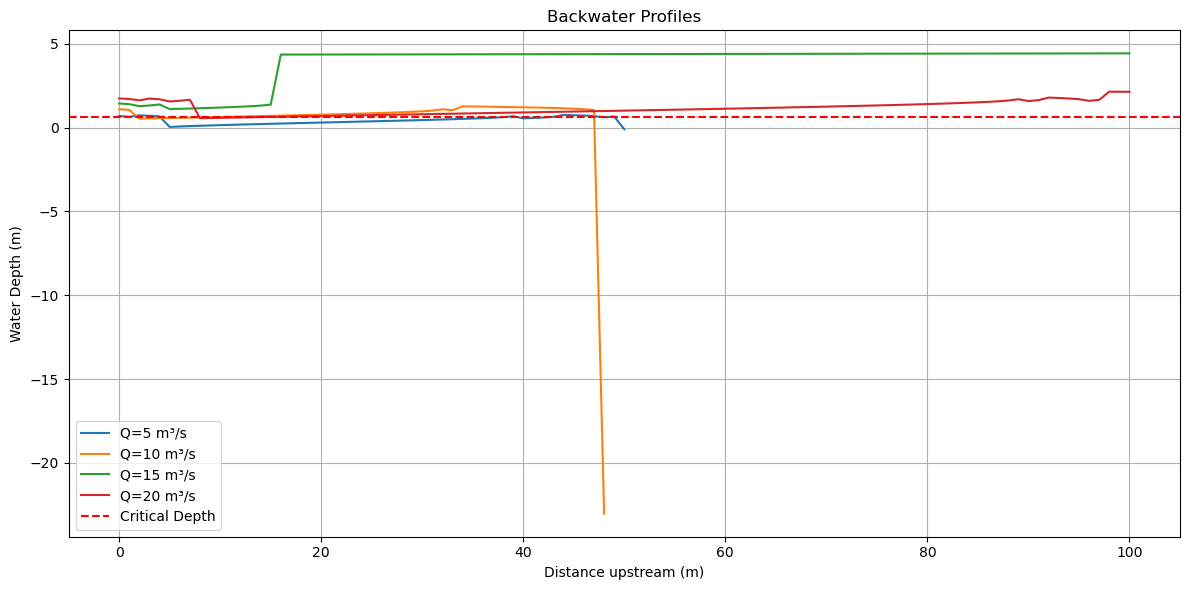

,Q (m³/s),Critical Depth (m),Normal Depth (m),Specific Energy (m),Sequent Depth (m)
0,5,0.656663,1.316382,0.987303,No jump
1,10,1.042388,1.995262,1.567246,No jump
2,15,1.365915,2.544806,2.053673,No jump
3,20,1.654688,3.024252,2.487848,No jump


C:\Users\williagp\PycharmProjects\WaterSurface\outputs\weir_flow_summary.csv

C:\Users\williagp\PycharmProjects\WaterSurface\outputs\backwater_profiles.png

In [4]:
# Inputs
Q_list = [5, 10, 15, 20]
b = 3.0
n = 0.03
S0 = 0.001
L = 100.0
dx = 1.0
weir_type = 'broad-crested'
weir_height = 1.0
C_b = 1.7
C_d = 0.6

# Run analysis
analyze_and_plot(Q_list, b, n, S0, L, dx, weir_type, weir_height, C_b, C_d)

In [5]:
flow_selector = widgets.SelectMultiple(
    options=[5, 10, 15, 20, 25],
    value=[10],
    description='Flow Rates Q (m³/s)',
)

ui = widgets.VBox([
    flow_selector,
    widgets.FloatSlider(value=3.0, min=1.0, max=10.0, step=0.5, description='Channel Width b (m)'),
    widgets.FloatSlider(value=0.03, min=0.01, max=0.1, step=0.005, description="Manning's n"),
    widgets.FloatLogSlider(value=0.001, base=10, min=-4, max=-1, step=0.1, description='Slope S₀'),
    widgets.FloatSlider(value=100.0, min=10, max=300, step=10, description='Length L (m)'),
    widgets.FloatSlider(value=1.0, min=0.1, max=5.0, step=0.1, description='dx Step (m)'),
    widgets.Dropdown(options=['broad-crested', 'sharp-crested'], value='broad-crested', description='Weir Type'),
    widgets.FloatSlider(value=1.0, min=0.5, max=3.0, step=0.1, description='Weir Height (m)'),
    widgets.FloatSlider(value=1.7, min=1.0, max=2.5, step=0.1, description='C_b (broad)'),
    widgets.FloatSlider(value=0.6, min=0.4, max=0.9, step=0.05, description='C_d (sharp)'),
])

out = widgets.interactive_output(
    analyze_and_plot,
    {
        'Q_list': flow_selector,
        'b': ui.children[1],
        'n': ui.children[2],
        'S0': ui.children[3],
        'L': ui.children[4],
        'dx': ui.children[5],
        'weir_type': ui.children[6],
        'weir_height': ui.children[7],
        'C_b': ui.children[8],
        'C_d': ui.children[9]
    }
)

display(ui, out)

Output()